In [2]:
import sys
import gym
from gym import wrappers, logger
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np

/Users/adammarblestone/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

In [3]:
def run_RandomAgent():

    env = gym.make('SpaceInvaders-v0')

    outdir = 'agent-results'
    env = wrappers.Monitor(env, directory=outdir, force=True)

    #logger.set_level(logger.INFO)

    agent = RandomAgent(env.action_space)

    reward = 0
    done = False
    observation = env.reset()

    for t in range(1000):
        action = agent.act(observation, reward, done)
        observation, reward, done, _ = env.step(action)

        print("Step %i taken" %t)

        if done:
            break

    env.close()

In [4]:
# Now start doing some interesting RL

# Inspired closely by https://gist.github.com/shanest/535acf4c62ee2a71da498281c2dfc4f4

class PolicyGradientAgent_FullyConnected(object):
    def __init__(self, env, session):
        self.env = env
        self.action_space = env.action_space
        self.state_space = env.observation_space
        self.session = session
        
        first_layer_size = 10
        
        # Define variables: to map state space into action space with a 2-layer network
        
        # Use for Atari: 
        # num_input_dimensions = self.state_space.shape[0] * self.state_space.shape[1] * self.state_space.shape[2]
        # Use for Cart-Pole:
        num_input_dimensions = self.state_space.shape[0]
        
        self.W1 = tf.Variable(tf.random_normal([num_input_dimensions, first_layer_size]))
        self.b1 = tf.Variable(tf.zeros([first_layer_size]))
        self.W2 = tf.Variable(tf.random_normal([first_layer_size, self.action_space.n]))
        self.b2 = tf.Variable(tf.zeros([self.action_space.n]))
        
        # Define the computational graph of the network
        self.x=tf.placeholder(shape=[None,num_input_dimensions],dtype=tf.float32, name = 'x')
        self.hidden = tf.nn.relu(tf.add(tf.matmul(self.x,self.W1), self.b1))
        self.output = tf.nn.sigmoid(tf.add(tf.matmul(self.hidden,self.W2), self.b2))
        self.sample = tf.reshape(tf.multinomial(self.output, 1), [])

        self.observation_history = tf.placeholder(shape=[None, num_input_dimensions],dtype=tf.float32, name = 'observationhist')
        self.action_history = tf.placeholder(shape=[None],dtype=tf.int32, name = "actionhistory")
        self.reward_history = tf.placeholder(shape=[None],dtype=tf.float32, name = "rewardhistory")
        self.advantages = tf.placeholder(shape=[None],dtype=tf.float32, name = 'advantages')
        
        # Define the loss function and optimizer
        # Inspired by https://gist.github.com/shanest/535acf4c62ee2a71da498281c2dfc4f4
        self.log_probs = tf.log(tf.nn.softmax(self.output))
        indices = tf.range(0, tf.shape(self.log_probs)[0]) * tf.shape(self.log_probs)[1] + self.action_history
        self.probs_of_actions_taken = tf.gather(tf.reshape(self.log_probs, [-1]), indices)
        self.loss = -1*tf.reduce_mean(tf.multiply(self.probs_of_actions_taken, self.advantages))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = 0.1)
        self.training = self.optimizer.minimize(self.loss)
        
    def act(self, observation):
        # Choose actions with probability given by self.output
        action = self.session.run(self.sample, feed_dict = {self.x: [tf.reshape(observation,[-1]).eval(session=self.session)]})
        return action
    
    def discount_rewards(self, r): # From https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb
        """ take 1D float array of rewards and compute discounted reward """
        gamma = 0.99
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(xrange(0, len(r))):
            running_add = running_add * gamma + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def rollout(self): # From https://gist.github.com/shanest/535acf4c62ee2a71da498281c2dfc4f4
        """Run one episode."""

        observation, reward, done = self.env.reset(), 0, False
        obs, acts, rews = [], [], []

        while not done:
            obs.append(observation)

            action = self.act(observation)
            observation, reward, done, _ = self.env.step(action)

            acts.append(action)
            rews.append(reward)
                        
        obs_hist = np.asarray([tf.reshape(o,[-1]).eval(session=self.session) for o in obs])
        advs = np.asarray(self.discount_rewards(rews)) 
        acts = np.asarray(acts, dtype = np.int32)
        rews = np.asarray(rews, dtype = np.float32)
        
        return rews, acts, obs_hist, advs
        
    def train(self, rews, acts, obs_hist, advs):        
        l, _ = self.session.run([self.loss, self.training], feed_dict = {self.x:obs_hist,\
                                                                         self.advantages:advs,\
                                                                         self.action_history:acts,\
                                                                         self.reward_history:rews})
        return l

In [5]:
# Let's try it batch-wise

def batchwise_run_PolicyGradientAgent_FullyConnected(env_string):
    
    env = gym.make(env_string)

    from os.path import expanduser
    home = expanduser("~")

    now = datetime.datetime.now()
    s = now.strftime("%H%M%S-%B%d%Y")
    outdir = home + "/Desktop/" +'agent-results/' + s
    env = wrappers.Monitor(env, outdir, force = True, video_callable=lambda episode_id: episode_id%15==0) # Save every 10th video

    # logger.set_level(logger.INFO)

    with tf.Graph().as_default(), tf.Session() as sess:

        agent = PolicyGradientAgent_FullyConnected(env, sess)

        sess.run(tf.initialize_all_variables())

        num_batches = 10
        reward_totals = []
        losses = []
        for b in range(num_batches):
            print ("Running batch %i" % b)
            num_episodes = 15
            print("\tRunning episodes...")            
            b_rews, b_acts, b_obs_hist, b_advs = [],[],[],[]
            for rollout in range(num_episodes):
                if rollout % 5 == 0:
                    print("\t\tRollout %i" % rollout)
                # print("Roll-out %i" % rollout)
                rews, acts, obs_hist, advs = agent.rollout()
                # print("Training step %i" % rollout)
                b_rews.extend(rews)
                b_acts.extend(acts)
                b_obs_hist.extend(obs_hist)
                b_advs.extend(advs)
                
            b_advs = (b_advs - np.mean(b_advs)) / (np.std(b_advs) + 1e-10) # Normalized advantages
            print("\tTraining step...")
            loss = agent.train(b_rews, b_acts, b_obs_hist, b_advs)

            reward_totals.append(np.sum(b_rews)/float(num_episodes))
            losses.append(loss/float(num_episodes))
            
            if b > 0:
                plt.figure()
                fig = plt.figure()
                ax1 = fig.add_subplot(111)
                horiz = range(len(reward_totals))
                ax1.plot(horiz, reward_totals, 'b-')
                ax1.set_ylabel('Rewards', color='b')
                ax2 = ax1.twinx()
                ax2.plot(horiz, losses, 'r-')
                ax2.set_ylabel('Loss', color='r')
                for tl in ax1.get_yticklabels():
                    tl.set_color('b')
                for t2 in ax2.get_yticklabels():
                    t2.set_color('r')
                plt.show()

        sess.close()

    env.close()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


/Users/adammarblestone/anaconda/envs/py27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Running batch 0
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...
Running batch 1
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


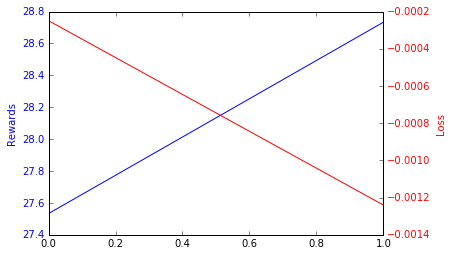

Running batch 2
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


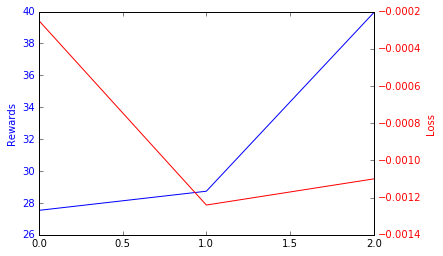

Running batch 3
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


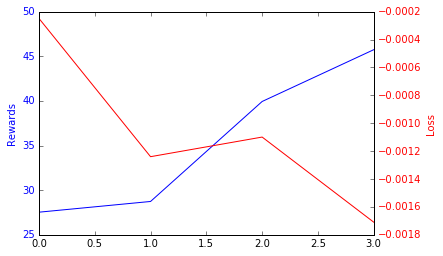

Running batch 4
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


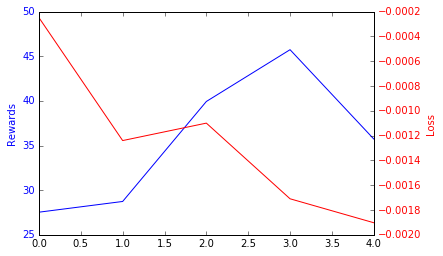

Running batch 5
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


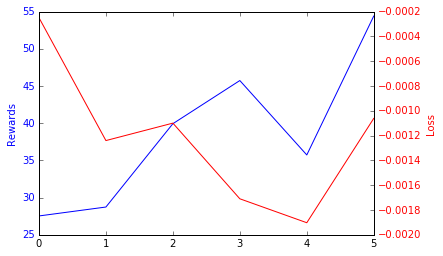

Running batch 6
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


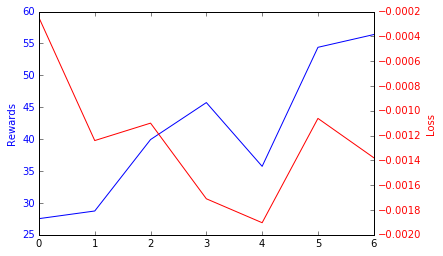

Running batch 7
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


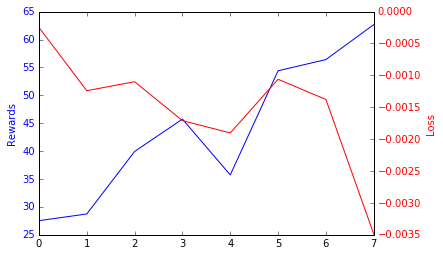

Running batch 8
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


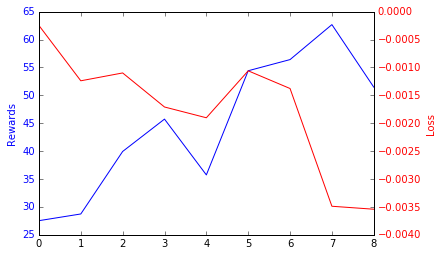

Running batch 9
	Running episodes...
		Rollout 0
		Rollout 5
		Rollout 10
	Training step...


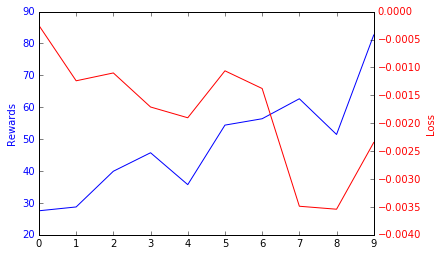

In [6]:
batchwise_run_PolicyGradientAgent_FullyConnected('CartPole-v0')

# batchwise_run_PolicyGradientAgent_FullyConnected('Acrobot-v1') 
# Acrobot takes ridiculously longer to run rollouts

# batchwise_run_PolicyGradientAgent_FullyConnected('SpaceInvaders-v0') # Make sure to set flag

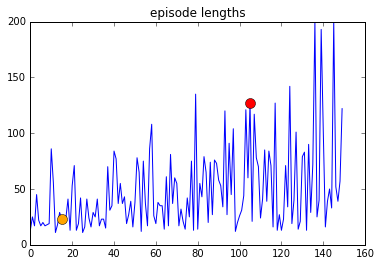

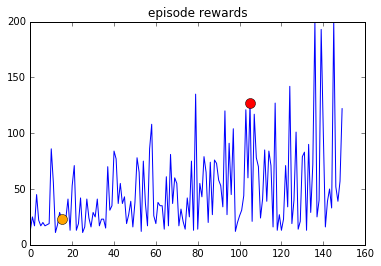

In [11]:
stats = {"episode_lengths": [13, 25, 17, 45, 22, 17, 20, 17, 18, 19, 86, 56, 11, 18, 29, 23, 24, 24, 41, 13, 53, 71, 13, 19, 42, 11, 16, 41, 24, 16, 29, 25, 41, 17, 23, 23, 15, 70, 31, 35, 84, 77, 37, 55, 37, 43, 19, 27, 39, 16, 38, 78, 65, 12, 75, 37, 17, 86, 108, 26, 19, 38, 35, 35, 14, 61, 17, 81, 37, 60, 55, 17, 32, 21, 14, 42, 25, 75, 13, 135, 14, 55, 43, 79, 65, 20, 74, 27, 76, 73, 58, 53, 34, 120, 27, 91, 45, 104, 12, 20, 26, 31, 44, 121, 60, 127, 21, 117, 78, 70, 24, 41, 85, 39, 84, 71, 16, 127, 13, 27, 13, 23, 71, 34, 142, 19, 40, 101, 14, 21, 79, 83, 13, 90, 29, 72, 200, 25, 40, 193, 102, 16, 39, 50, 33, 200, 52, 39, 57, 122], "episode_rewards": [13.0, 25.0, 17.0, 45.0, 22.0, 17.0, 20.0, 17.0, 18.0, 19.0, 86.0, 56.0, 11.0, 18.0, 29.0, 23.0, 24.0, 24.0, 41.0, 13.0, 53.0, 71.0, 13.0, 19.0, 42.0, 11.0, 16.0, 41.0, 24.0, 16.0, 29.0, 25.0, 41.0, 17.0, 23.0, 23.0, 15.0, 70.0, 31.0, 35.0, 84.0, 77.0, 37.0, 55.0, 37.0, 43.0, 19.0, 27.0, 39.0, 16.0, 38.0, 78.0, 65.0, 12.0, 75.0, 37.0, 17.0, 86.0, 108.0, 26.0, 19.0, 38.0, 35.0, 35.0, 14.0, 61.0, 17.0, 81.0, 37.0, 60.0, 55.0, 17.0, 32.0, 21.0, 14.0, 42.0, 25.0, 75.0, 13.0, 135.0, 14.0, 55.0, 43.0, 79.0, 65.0, 20.0, 74.0, 27.0, 76.0, 73.0, 58.0, 53.0, 34.0, 120.0, 27.0, 91.0, 45.0, 104.0, 12.0, 20.0, 26.0, 31.0, 44.0, 121.0, 60.0, 127.0, 21.0, 117.0, 78.0, 70.0, 24.0, 41.0, 85.0, 39.0, 84.0, 71.0, 16.0, 127.0, 13.0, 27.0, 13.0, 23.0, 71.0, 34.0, 142.0, 19.0, 40.0, 101.0, 14.0, 21.0, 79.0, 83.0, 13.0, 90.0, 29.0, 72.0, 200.0, 25.0, 40.0, 193.0, 102.0, 16.0, 39.0, 50.0, 33.0, 200.0, 52.0, 39.0, 57.0, 122.0]}

plt.figure()
plt.title("episode lengths")
plt.plot(stats["episode_lengths"])
plt.plot([15], [stats["episode_lengths"][15]], marker='o', markersize=10, color="orange")
plt.plot([105], [stats["episode_lengths"][105]], marker='o', markersize=10, color="red")
plt.figure()
# Best recorded video was at episode 105
plt.title("episode rewards")
plt.plot(stats["episode_rewards"])
plt.plot([15], [stats["episode_rewards"][15]], marker='o', markersize=10, color="orange")
plt.plot([105], [stats["episode_rewards"][105]], marker='o', markersize=10, color="red")
plt.show()

In [7]:
# Doing Q-learning based directly on
# https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

class QLearningAgent_FullyConnected(object):
    def __init__(self, env, session):
        self.env = env
        self.action_space = env.action_space
        self.state_space = env.observation_space
        self.session = session
        
        self.observation, self.total_reward, self.done = self.env.reset(), 0, False
        
        self.e = 0.1 # Chance of random action
                
        # Define variables: to map state space into action space with a 2-layer network
        
        # Use for Atari: 
        # num_input_dimensions = self.state_space.shape[0] * self.state_space.shape[1] * self.state_space.shape[2]
        
        # Use for Frozen-Lake
        num_input_dimensions = 16

        # Use for Cart-Pole:
        # num_input_dimensions = self.state_space.shape[0]
                
        self.W1 = tf.Variable(tf.random_uniform([num_input_dimensions,self.action_space.n],0,0.01))
        
        
        # Define the computational graph of the network
        self.x = tf.placeholder(shape=[None,num_input_dimensions],dtype=tf.float32, name = 'x')
        self.Qout = tf.matmul(self.x,self.W1)
        self.predict = tf.argmax(self.Qout,1)
        
        self.nextQ = tf.placeholder(shape = [None, self.action_space.n], dtype=tf.float32, name = 'nextQ')
        self.loss = tf.reduce_sum(tf.square(self.nextQ - self.Qout))
        self.trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
        self.updateModel = self.trainer.minimize(self.loss)
                
    def reset(self):
        self.observation, self.total_reward, self.done = self.env.reset(), 0, False
        
        # Use for Frozen-Lake only
        self.observation = np.identity(16)[self.observation:self.observation+1]
    
    def act(self):
        
        # Parameters
        y = .99
        
        #Choose an action greedily (with e chance of random action) from the Q-network
        a, allQ = self.session.run([self.predict,self.Qout],feed_dict={self.x:self.observation})
        # Use [self.observation] for other than Frozen-Lake
        
        if np.random.rand(1) < self.e:
            a[0] = self.env.action_space.sample()
            
        #Get new state and reward from environment
        s1,r,d,_ = self.env.step(a[0])
        
        # Use for Frozen-Lake only
        s1 = np.identity(16)[s1:s1+1]
            
        #Obtain the Q' values by feeding the new state through our network
        Q1 = self.session.run(self.Qout,feed_dict={self.x:s1})
        # Use [s1] for other than Frozen-Lake

        #Obtain maxQ' and set our target value for chosen action.
        maxQ1 = np.max(Q1)
        targetQ = allQ
        targetQ[0,a[0]] = r + y*maxQ1
        
        #Train our network using target and predicted Q values
        l, _ = self.session.run([self.loss, self.updateModel],feed_dict={self.x:self.observation,self.nextQ:targetQ})
        # Use [self.observation] for other than Frozen-Lake
        
        # Update the internal state
        self.observation = s1
        
        self.total_reward += r
        self.done = d

In [8]:
def run_QLearningAgent_FullyConnected(env_string):
    
    env = gym.make(env_string)

    from os.path import expanduser
    home = expanduser("~")

    now = datetime.datetime.now()
    s = now.strftime("%H%M%S-%B%d%Y")
    outdir = home + "/Desktop/" +'agent-results/' + s
    
    env = wrappers.Monitor(env, outdir, force = True, video_callable=lambda episode_id: episode_id%1000==0)
    # logger.set_level(logger.INFO)

    with tf.Graph().as_default(), tf.Session() as sess:

        agent = QLearningAgent_FullyConnected(env, sess)

        sess.run(tf.initialize_all_variables())
        
        num_episodes = 2000
        rewards_across_episodes = []
        js = []
        
        for ep in range(num_episodes):
            
            if ep % 1000 == 0:
                print("Episode %i" % ep)
            
            agent.reset()
            j = 0
            while agent.done == False:
                agent.act()
                j += 1
                
            agent.e = 1./((ep/50) + 10) # Decrease random exploration
            js.append(j)
            rewards_across_episodes.append(agent.total_reward)
            
        sess.close()
    
    env.close
    
    plt.figure()
    plt.plot(rewards_across_episodes)    
    plt.figure()
    plt.plot(js)
    plt.show()

Episode 0
Episode 1000


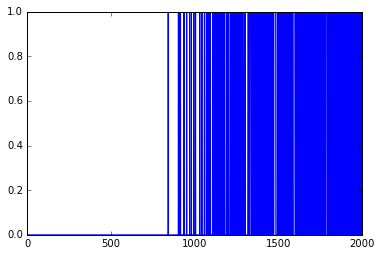

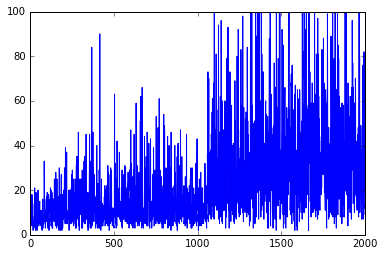

In [9]:
# run_QLearningAgent_FullyConnected('CartPole-v0')
run_QLearningAgent_FullyConnected('FrozenLake-v0')